In [1]:
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
from astropy.io import fits
import cv2
import galsim
import pandas as pd
from scipy.ndimage import gaussian_filter
%pylab inline
from astropy.table import Table

from astropy import units as u
from astropy import constants as const
import lenstronomy.Plots.lens_plot as lp

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import standard python modules
# you may need to install lenstronomy and Anaconda environment
# pip install lenstronomy==1.10.2
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
import lenstronomy.Util.param_util as param_util

In [3]:
hdul = fits.open('../PSF_sub_J0746/J0746-z_fit_PSFs_one_sersic.fits')
dof=hdul[0].header['DOF']
chi2_0=hdul[0].header['CHI2']
ppar0=(hdul[3].data).p_phot
img=hdul[4].data
model0=hdul[6].data
hdul.close()

## 读取位置，这里ra dec不重要。只需要读取从之前建模中得到的PSF位置和中心星系位置就行

ppar0的含义：

ppar0[0:13]是第一个PSF的参数
#PSF1_amp             [0]
#PSF1_x               [1]
#PSF1_y               [2]
#PSF1_alpha           [3]
#PSF1_PHI             [4]
#PSF1_q               [5]
#PSF1_beta            [6]
#PSF2_amp             [7]
#PSF2_x               [8]
#PSF2_y               [9]
#PSF2_alpha           [10]
#PSF2_PHI             [11]
#PSF2_q               [12]
#PSF2_beta            [13]

ppar0[14:28]是第二个PSF的参数

#PSF1_amp             [14]
#PSF1_x               [15]
#PSF1_y               [16]
#PSF1_alpha           [17]
#PSF1_PHI             [18]
#PSF1_q               [19]
#PSF1_beta            [20]
#PSF2_amp             [21]
#PSF2_x               [22]
#PSF2_y               [23]
#PSF2_alpha           [24]
#PSF2_PHI             [25]
#PSF2_q               [26]
#PSF2_beta            [27]

ppar0[28:] 是sersic 参数，按顺序：
#peak value of sersic [28]
#location x of sersic [29]
#location y of sersic [30]
#effective radius     [31]
#position angle       [32]
#q                    [33]
#sersic index         [34]
#background           [35]

In [4]:
e1_light,e2_light=np.round(param_util.phi_q2_ellipticity(phi=(ppar0[32]-90)/180.0*np.pi,q=ppar0[33]),2)

In [5]:
e1_light,e2_light

(0.19, 0.26)

In [6]:
phi= ppar0[32]
q  = ppar0[33]
img1_x = ppar0[1]
img1_y = ppar0[2]

img2_x = ppar0[15]
img2_y = ppar0[16]

gal_x = ppar0[29]
gal_y = ppar0[30]

img1_x_mod = img1_x-gal_x
img1_y_mod = img1_y-gal_y
img2_x_mod = img2_x-gal_x
img2_y_mod = img2_y-gal_y

pix_scale=0.262
x_image_data = np.array([img1_x_mod,img2_x_mod])*pix_scale
y_image_data = np.array([img1_y_mod,img2_y_mod])*pix_scale
xpos_err_data = np.array([0.01,0.01])
ypos_err_data = np.array([0.01,0.01])


from scipy.optimize import minimize
from itertools import permutations


def sort(x_image_model, x_image_data, y_image_model, y_image_data, xpos_err_data, ypos_err_data):
    # 定义目标函数
    def objective_function(indices):
        # 重新排列模型数组
        reordered_x_model = x_image_model[list(indices)]
        reordered_y_model = y_image_model[list(indices)]
        
        # 计算目标函数
        res = np.sum((reordered_x_model - x_image_data)**2 / xpos_err_data**2 +
                     (reordered_y_model - y_image_data)**2 / ypos_err_data**2)
        return res

    # 获取所有可能的排列
    index_permutations = permutations(range(len(x_image_model)))

    # 初始化最小值和最佳排列
    min_value = float('inf')
    best_permutation = None

    # 遍历所有排列，寻找最小化目标函数的排列
    for perm in index_permutations:
        current_value = objective_function(perm)
        if current_value < min_value:
            min_value = current_value
            best_permutation = perm

    # 根据最佳排列重新排序x_image_model和y_image_model
    sorted_x_image_model = x_image_model[list(best_permutation)]
    sorted_y_image_model = y_image_model[list(best_permutation)]

    # 返回重新排序的数组
    return sorted_x_image_model, sorted_y_image_model


def chi2(x_image_model, y_image_model):
    
    if len(x_image_model)!=len(x_image_data):
        return 1e90
    
    
    x_image_model_sorted, y_image_model_sorted = \
    sort(x_image_model, x_image_data, y_image_model, y_image_data, xpos_err_data, ypos_err_data)
    
    res=(x_image_model_sorted - x_image_data)**2 / xpos_err_data**2 + \
        (y_image_model_sorted - y_image_data)**2 / ypos_err_data**2
    return res.sum()

def GetModelSolution(e1,e2,xs1,xs2,theta_E,plot=False):
    
    lensEquationSolver = LensEquationSolver(LensModel(['SIE'])) 

    kwargs_sie = {'theta_E': theta_E, 'e1':e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0.0}
    kwargs_lens_list = [kwargs_sie]    
        
    x, y = lensEquationSolver.image_position_from_source(
    kwargs_lens=kwargs_lens_list, 
    sourcePos_x=xs1, 
    sourcePos_y=xs2, 
    min_distance=0.01, 
    search_window=5, 
    precision_limit=10**(-10), 
    num_iter_max=30,
    solver='lenstronomy',
    non_linear=False,
    arrival_time_sort=False,)
    
    if plot:
    
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        lp.lens_model_plot(ax,LensModel(['SIE']),kwargs_lens_list,point_source=True,with_caustics=True,\
                          with_convergence=False,sourcePos_x=xs1,sourcePos_y=xs2)
    
    
    return x,y

/home/zizhao/anaconda3/envs/lqmassfit/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)


e1: 0.13219249131754524 ± nan
e2: -0.1182117302595917 ± nan
xs1: 0.3212031341709596 ± nan
xs2: -0.4407424101743472 ± nan
theta_E: 1.2879403365994475 ± nan


(array([ 0.63174251, -0.5098455 ]), array([-1.70085743,  0.46160777]))

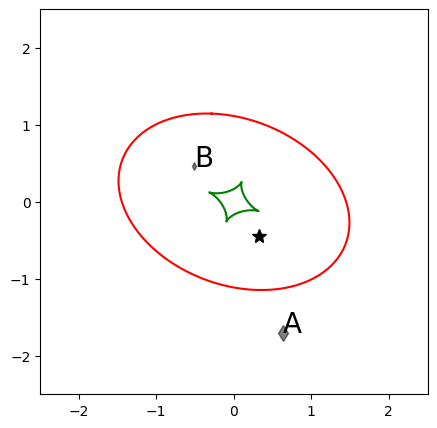

In [24]:


# Assuming ppar0 and other necessary imports and definitions are provided above this code

def objective(params):
    e1, e2, xs1, xs2, theta_E = params
    x_image_model, y_image_model = GetModelSolution(e1, e2, xs1, xs2, theta_E, plot=False)
    return chi2(x_image_model, y_image_model)

# Initial guess for the parameters
initial_guess = [0.11, -0.13, 0.3, -0.35, 1]
# initial_guess=[0.22752506082081317, 0.0507744936806883,  0.2626, -0.481422, 1.208]

# Perform the optimization
result = minimize(objective, initial_guess, method='Nelder-Mead')

# Extract the optimized parameters
optimized_params = result.x
e1_opt, e2_opt, xs1_opt, xs2_opt, theta_E_opt = optimized_params

# Calculate error bars using the square root of the diagonal elements of the covariance matrix
# Note: To get a proper covariance matrix, one might need to use methods that estimate it, such as least_squares with 'trf' or 'dogbox' method
# Here we provide a placeholder approach as an example
try:
    error_bars = np.sqrt(np.diag(result.hess_inv.todense()))
except AttributeError:
    # If the Hessian is not available, error bars cannot be directly calculated
    error_bars = np.full_like(optimized_params, np.nan)

# Print optimized parameters and their error bars
param_names = ['e1', 'e2', 'xs1', 'xs2', 'theta_E']
for name, value, error in zip(param_names, optimized_params, error_bars):
    print(f"{name}: {value} ± {error}")

# Optionally, plot the solution
GetModelSolution(e1_opt, e2_opt, xs1_opt, xs2_opt, theta_E_opt, plot=True)

In [25]:
e1_opt, e2_opt, xs1_opt, xs2_opt, theta_E_opt

(0.13219249131754524,
 -0.1182117302595917,
 0.3212031341709596,
 -0.4407424101743472,
 1.2879403365994475)

In [27]:
# result.hess_inv.todense()

In [28]:
x_image_ini,y_image_ini = GetModelSolution(0.22752506082081317, 0.0507744936806883,  0.2626, -0.481422, 1.208,plot=False)
x_image_opt,y_image_opt = GetModelSolution(e1_opt, e2_opt, xs1_opt, xs2_opt, theta_E_opt,plot=False)
print("initial_chi2:",chi2(x_image_ini,y_image_ini))
print("opt_chi2:",chi2(x_image_opt,y_image_opt))
print("improve:",chi2(x_image_ini,y_image_ini)/chi2(x_image_opt,y_image_opt))

initial_chi2: 0.00031878147160566757
opt_chi2: 5.58905700901975e-05
improve: 5.703671855399053


0.00031878189358618364

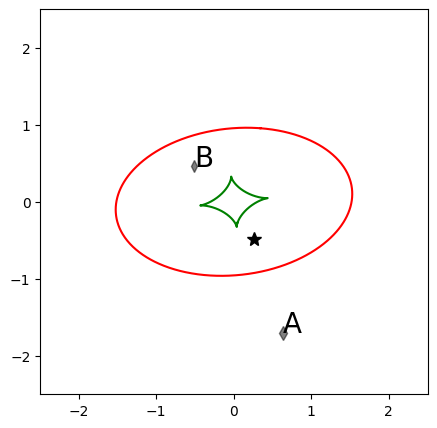

In [29]:
e1tst,e2tst=param_util.phi_q2_ellipticity(phi=(96.29+90)/180.0*np.pi, q=0.6219)
x_image_tst,y_image_tst = GetModelSolution(e1tst, e2tst, 0.2626, -0.481422, 1.208, plot=True)
chi2(x_image_tst,y_image_tst)

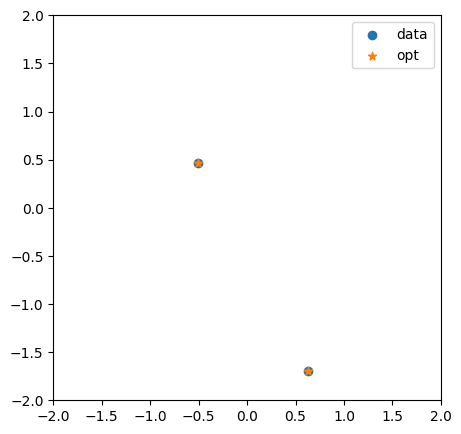

In [30]:
pl.figure(figsize=(5,5))
pl.scatter(x_image_data,y_image_data,label="data")
pl.scatter(x_image_opt,y_image_opt,label="opt",marker="*")
# pl.scatter(x_image_ini,y_image_ini,label="ini")
# pl.scatter(x_image_tst,y_image_tst,label="lmfit",marker="*")
pl.xlim(-2,2)
pl.ylim(-2,2)
pl.legend()

In [13]:
param_util.ellipticity2phi_q(e1_opt,e2_opt)

(0.10978120995044376, 0.6219)

In [14]:
np.rad2deg(0.1097812099504437)

6.290000000000021

In [15]:
e1_opt,e2_opt

(0.22752506082081317, 0.0507744936806883)

In [16]:
ppar0[32]-90

27.027553395592534

In [23]:
minimize?